# Data Setup for Analytical Dashboard to explore generated Clusters

1. This notebook is for developing functions to make sense of clusters created
2. prepare a database as a backend for a streamlit dashboard for ease of applying the functions we develop here

Functions:

- Top words and WordCloud creation based on Most frequent words in a topic scored/normalized by TF-IDF
- Similarity search function to find a input mock email and find most similar topics generated from enron 
- SQL functions to export/import prepared data to a persistent sql lite database
    - email and embedding data - Used for similarity search
    - email, cluster tags and probabilty (how strong an email belongs to the assigned cluster). This is used to rank most representative email for a cluster selected
    - Aggregated data by Cluster, Month,  Sender and Person owning a mail box, sub-mail box (inbox, deleted, etc folders) to easily retrieve email frequency by different dimensions



## 1. Environment Set Up 


Run the following to create dashenv and install requirements.txt

cd ..\team_project_ind5003\4_enron_mail_nlp 
*or where you saved your project*

python -m venv .dashenv 
*if it does not work try py -m venv .dashenv*

.dashenv\scripts\activate

pip install -r requirements.txt

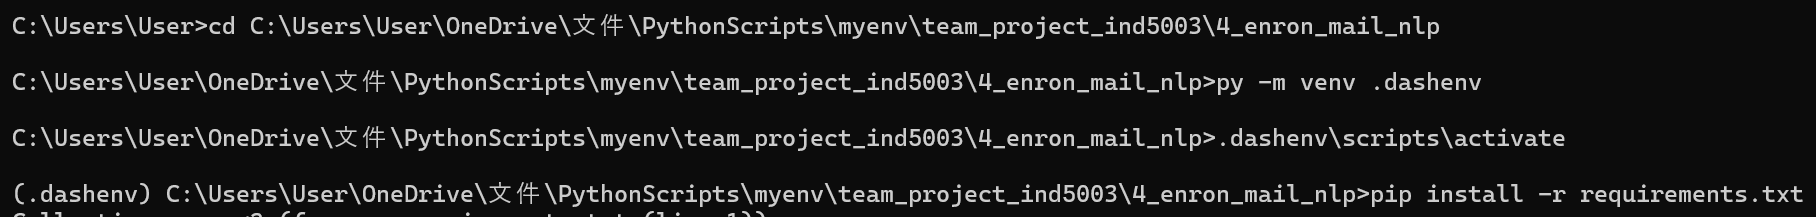




## 2a. Set up the Database

Copy Or unzip enron.db file in your \data sub-directory

Location:
4_enron_mail_nlp\data\enron.db

*note: no need to run **4. Function creation for dashboard and Database data export** if you already copied an updated enron.db*

## 2b. Saving streamlit application

Save a copy of enron_streamlit.py in your \notebook_scripts sub-directory

Location:
4_enron_mail_nlp\notebooks_scripts\enron_streamlit.py

## 3. Launching Dashboard

via cmd line:

cd ..\team_project_ind5003\4_enron_mail_nlp 

.dashenv\scripts\activate

streamlit run notebooks_scripts\enron_streamlit.py

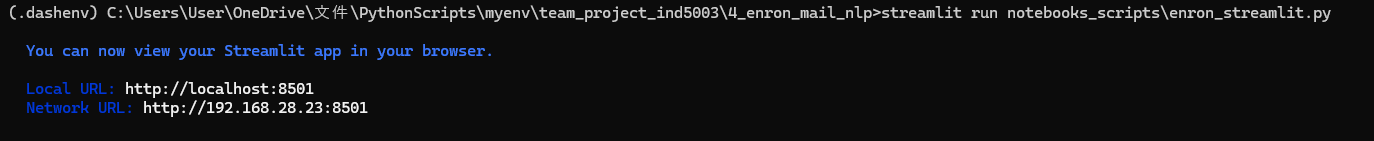


## 4. Function creation for dashboard and Database data export

In [3]:
# import dash
import transformers
import pandas as pd
import numpy as np
import plotly.express as px


### 4a. Read Clustered Dataframe


In [3]:
df_clean_2001_pick = pd.read_pickle('..\data\df_clean_2001_roberta_pick.pkl.gz', compression='gzip')

df_clean_2001_pick.head(2)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,possible_accounting,possible_hate_anger,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut,kmeans_clusters
0,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,0.102435,0.182009,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",2449,1.000000,259,56,348
1,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,0.212221,0.164912,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",2298,0.541348,259,56,306


In [4]:
print(df_clean_2001_pick['hdbscan_clusters_roberta'].unique().shape)

(4749,)


In [5]:
df_clean_2001_pick.columns

Index(['subject', 'date_short', 'message_id', 'from_addr', 'person_box',
       'sub_mailbox', 'sub_mailbox2', 'email_body', 'cleaned_email_body',
       'possible_accounting', 'possible_hate_anger', 'embedding_roberta',
       'embedding_roberta_reduced', 'hdbscan_clusters_roberta',
       'hdbscan_clusters_roberta_prob', 'reduced_labels_dbscan_cut',
       'reduced_labels_scipy_cut', 'kmeans_clusters'],
      dtype='object')

In [3]:
# Deduplicate based on the 'ID' column, keeping the first occurrence
df_clean_2001_pick_dedupe = df_clean_2001_pick[['email_body','cleaned_email_body','embedding_roberta','embedding_roberta_reduced',\
                                                'hdbscan_clusters_roberta',
       'hdbscan_clusters_roberta_prob', 'reduced_labels_dbscan_cut',
       'reduced_labels_scipy_cut']].drop_duplicates(subset=['cleaned_email_body'], keep='first')
df_clean_2001_pick_dedupe.reset_index(drop=True, inplace=True)
df_clean_2001_pick_dedupe.shape

(127111, 8)

### 4b. Create Topic Labels and Word Clouds for each Cluster

Clustering only gave us indices for each topic, looking into the top words / word clouds can help tell us what the email collection within an index talks about

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the default English stopwords
combined_stopwords = list(ENGLISH_STOP_WORDS)

# Add your custom stopwords to the list
combined_stopwords.extend(['messages', 'document', 'file', 'enron', 'subject', 
                           'ect', 'hou', 'com', 'recipient', 'from', 'sent', 'to', 
                           'cc', 'pm', 'am', 'http', 'www', 're', 'fw',
                           'sender', 'email', 'recipient', 'ect', 'hour', 'com',
                           'original', 'message', 'send','schedule','notes','2001',])


def get_top_tfidf_words(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words=combined_stopwords,token_pattern=r'\b[A-Za-z]+\b')
    try:
        X = vectorizer.fit_transform(texts)
        indices = X.mean(axis=0).A1.argsort()[::-1][:top_n]
        features = vectorizer.get_feature_names_out()
        return [features[i] for i in indices]
    except ValueError:
        return []
    # else:
    #     return []

def create_cluster_labels(df, label_field, text_field, top_n=10):
    labels = df[label_field].unique()
    label_dict = {}
    for label in labels:
        if label == -1:
            continue  # Skip noise points if using HDBSCAN

        combined_text = " ".join(df[df[label_field]==label][text_field])
        if len(combined_text.strip()) > 10:  # Check if the combined text is not empty
            label_dict[label] = get_top_tfidf_words([combined_text], top_n)
        
    return label_dict

# Usage:
hdbscan_labels = create_cluster_labels(df_clean_2001_pick_dedupe, "hdbscan_clusters_roberta", "cleaned_email_body")
dbscan_labels = create_cluster_labels(df_clean_2001_pick_dedupe, "reduced_labels_dbscan_cut", "cleaned_email_body")
scipy_labels = create_cluster_labels(df_clean_2001_pick_dedupe, "reduced_labels_scipy_cut", "cleaned_email_body")


In [16]:
df_hdbscan_labels = pd.DataFrame(list(hdbscan_labels.items()), columns=['topic', 'labels'])
df_dbscan_labels = pd.DataFrame(list(dbscan_labels.items()), columns=['topic', 'labels'])
df_scipy_labels = pd.DataFrame(list(scipy_labels.items()), columns=['topic', 'labels'])

df_hdbscan_labels['labels']= df_hdbscan_labels['labels'].apply(lambda x: ', '.join(x))
df_dbscan_labels['labels']= df_dbscan_labels['labels'].apply(lambda x: ', '.join(x))
df_scipy_labels['labels']= df_scipy_labels['labels'].apply(lambda x: ', '.join(x))
df_hdbscan_labels


,topic,labels
0,2449,"image, receive, click, unsubscribe, offers, e,..."
1,2298,"energy, register, central, news, e, daily, mai..."
2,353,"feedback, pep, process, management, performanc..."
3,3793,"s, percent, buy, money, stocks, company, earni..."
4,1858,"thestreet, subscriber, qpass, free, web, trial..."
...,...,...
4743,345,"report, east, power, position, desk, daily, y,..."
4744,270,"report, position, americas, y, named, linkfrom..."
4745,360,"prices, power, peak, y, report, named, linkfro..."
4746,129,"east, price, power, y, report, named, linkfrom..."


In [17]:
print(df_hdbscan_labels.topic.nunique(), df_dbscan_labels.topic.nunique(), df_scipy_labels.topic.nunique())

4748 791 483


In [27]:
print(df_clean_2001_pick_dedupe.hdbscan_clusters_roberta.nunique(), df_clean_2001_pick_dedupe.reduced_labels_dbscan_cut.nunique(), df_clean_2001_pick_dedupe.reduced_labels_scipy_cut.nunique())

4749 792 500


In [18]:



def make_wordcloud(word_freq_dict):
    wc = WordCloud(width=400, height=300, background_color='white')
    wc.generate_from_frequencies(word_freq_dict)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# For each cluster, generate wordcloud:
from collections import Counter
def top_words_freq(texts, vectorizer=None, top_n=50):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(stop_words=combined_stopwords,token_pattern=r'\b[A-Za-z]+\b')
    try:
        X = vectorizer.fit_transform(texts)
        features = vectorizer.get_feature_names_out()
        weights = X.sum(axis=0).A1
        word_freq_dict = {features[i]: weights[i] for i in weights.argsort()[::-1][:top_n]}
    except :
        word_freq_dict = {'nothing':1}
    return word_freq_dict



In [19]:


def create_df_word_cloud(df, label_field, text_field, top_n=30):
    labels = df[label_field].unique()
    label_dict = {}
    for label in labels:
        if label == -1:
            continue  # Skip noise points if using HDBSCAN

        combined_text = " ".join(df[df[label_field]==label][text_field])
        if len(combined_text.strip()) > 10:  # Check if the combined text is not empty
            label_dict[label] = top_words_freq([combined_text], vectorizer=None, top_n=top_n)
        
    return label_dict

dbscan_labels_wc = create_df_word_cloud(df_clean_2001_pick_dedupe, "reduced_labels_dbscan_cut", "cleaned_email_body")
# df_dbscan_labels = pd.DataFrame(list(dbscan_labels.items()), columns=['topic', 'word_cloud'])
df_dbscan_labels[['topic', 'word_cloud']]=list(dbscan_labels_wc.items())

df_dbscan_labels.index = df_dbscan_labels['topic']
df_dbscan_labels

,topic,labels,word_cloud
topic,,,
259,259,"s, image, t, thanks, new, time, know, power, e...","{'s': 0.5381027843747801, 'image': 0.199453717..."
486,486,"feedback, pep, process, performance, managemen...","{'feedback': 0.5197682735588279, 'pep': 0.4166..."
693,693,"image, weather, kt, storm, forecast, winds, s,...","{'image': 0.3678235751915647, 'weather': 0.320..."
385,385,"business, meetings, s, group, team, golf, time...","{'business': 0.42064341126964216, 'meetings': ..."
2,2,"panel, panels, phillip, cost, johnnie, home, a...","{'panel': 0.28235511231217136, 'panels': 0.219..."
...,...,...,...
770,770,"report, east, power, position, desk, daily, y,...","{'report': 0.4743416490252569, 'east': 0.47434..."
783,783,"report, position, americas, y, named, linkfrom...","{'report': 0.6255432421712244, 'position': 0.4..."
785,785,"prices, power, peak, y, report, named, linkfro...","{'prices': 0.4472135954999579, 'power': 0.4472..."


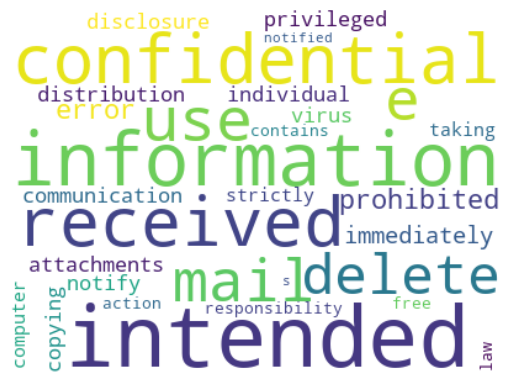

In [21]:
make_wordcloud(df_dbscan_labels.loc[122, 'word_cloud'])



In [22]:


hdbscan_labels_wc = create_df_word_cloud(df_clean_2001_pick_dedupe, "hdbscan_clusters_roberta", "cleaned_email_body")
df_hdbscan_labels[['topic', 'word_cloud']]=list(hdbscan_labels_wc.items())

df_hdbscan_labels.index = df_hdbscan_labels['topic']  
df_hdbscan_labels

,topic,labels,word_cloud
topic,,,
2449,2449,"image, receive, click, unsubscribe, offers, e,...","{'image': 0.9376358502435173, 'receive': 0.146..."
2298,2298,"energy, register, central, news, e, daily, mai...","{'energy': 0.4567009283847611, 'register': 0.2..."
353,353,"feedback, pep, process, management, performanc...","{'feedback': 0.5179016034389995, 'pep': 0.4291..."
3793,3793,"s, percent, buy, money, stocks, company, earni...","{'s': 0.5056457493795046, 'percent': 0.2459526..."
1858,1858,"thestreet, subscriber, qpass, free, web, trial...","{'thestreet': 0.4527383038003344, 'subscriber'..."
...,...,...,...
345,345,"report, east, power, position, desk, daily, y,...","{'report': 0.4743416490252569, 'east': 0.47434..."
270,270,"report, position, americas, y, named, linkfrom...","{'report': 0.6255432421712244, 'position': 0.4..."
360,360,"prices, power, peak, y, report, named, linkfro...","{'prices': 0.4472135954999579, 'power': 0.4472..."


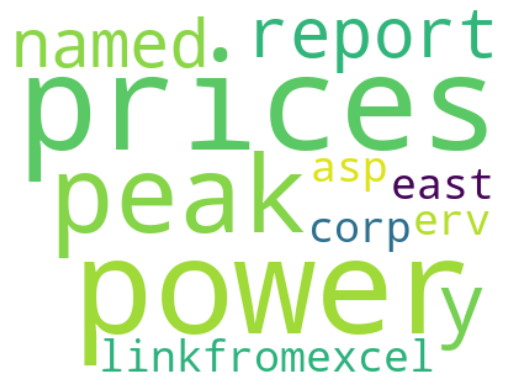

In [25]:
make_wordcloud(df_hdbscan_labels.loc[360, 'word_cloud'])

In [26]:

scipy_labels_wc = create_df_word_cloud(df_clean_2001_pick_dedupe, "reduced_labels_scipy_cut", "cleaned_email_body")
df_scipy_labels[['topic', 'word_cloud']]=list(scipy_labels_wc.items())

df_scipy_labels.index = df_scipy_labels['topic']  
df_scipy_labels

,topic,labels,word_cloud
topic,,,
56,56,"s, image, t, time, new, thanks, power, energy,...","{'s': 0.5284657399805909, 'image': 0.222784019..."
176,176,"team, outlook, migration","{'team': 0.5773502691896258, 'outlook': 0.5773..."
39,39,"futures, contained, charts, carr, s, expressed...","{'futures': 0.29851115706299675, 'contained': ..."
21,21,"pdf, research, carrfut, matrix, gas, contained...","{'pdf': 0.42407901954028426, 'research': 0.424..."
389,389,"outlook, owa, access, mailbox, web, client, ab...","{'outlook': 0.5224753596034531, 'owa': 0.44783..."
...,...,...,...
429,429,"threat, mile, island","{'threat': 0.5773502691896258, 'mile': 0.57735..."
356,356,"new, named, cfo","{'new': 0.5773502691896258, 'named': 0.5773502..."
257,257,"party, unrelated, longer, cfo, disclosure, evp...","{'party': 0.41702882811414954, 'unrelated': 0...."


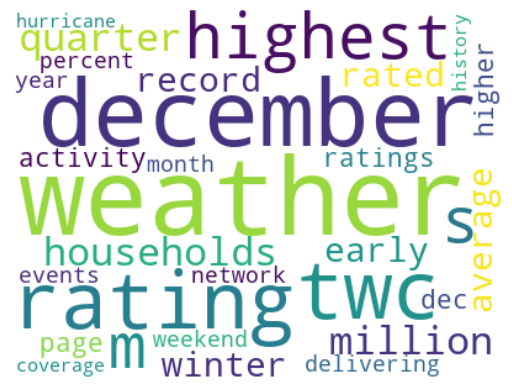

In [57]:
make_wordcloud(df_scipy_labels.loc[489, 'word_cloud'])


### 4c. Developing Functions for Text Retrieval / Finding Most similar topics TO an inputed paragraph / mock email

1. Retrieving a reprentative email will give more context on what is the topic is about
2. Another function is comparing two vectors using cosine similarity. One vector is a converted paragraph or mock email we want to compare to the an array of vector collection vectorized from enron emails


In [ ]:
from sentence_transformers import SentenceTransformer, util
import textwrap

model_roberta= SentenceTransformer('sentence-transformers/all-roberta-large-v1')
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

def similarity_to_inputlist(sample_embedding, compare_embeddings):
    max_score = -1  # Initialize with a very low value

    # sample_embedding=sample_embedding.astype(np.float32)
    # compare_embeddings=compare_embeddings.astype(np.float32)

    for comp_embedding in compare_embeddings:

        cosine_scores = util.cos_sim(sample_embedding, comp_embedding)

        if cosine_scores.item() > max_score:
            max_score = cosine_scores.item()

    return max_score

# test if it can find similarity in 100000 emails with accounting sentences:

def find_similar_emails(encoding_to_compare, df_clean_2001_pick, threshold=0.5, looking_for="accounting"):
    loaded_vector = np.array(df_clean_2001_pick['embedding_roberta'].to_list())
    for i,email_embding in enumerate(loaded_vector):
        score = similarity_to_inputlist(email_embding, encoding_to_compare)
        if score > threshold:
            print(f"Email: {df_clean_2001_pick.iloc[i]['subject']} - date/mailfolder: {df_clean_2001_pick.iloc[i]['date_short']} - {df_clean_2001_pick.iloc[i]['sub_mailbox']} - similarity to {looking_for}: {score}")
            print(f"From: {df_clean_2001_pick.iloc[i]['from_addr']}")
            print(f"Person_box: {df_clean_2001_pick.iloc[i]['person_box']}")
            print(textwrap.fill(df_clean_2001_pick.iloc[i]['cleaned_email_body'], width=100))
            print('-----------------------------------------------------------------------------------')



In [7]:

from sentence_transformers import SentenceTransformer, util
import textwrap



accounting_sentences = [
"""  I'm still a bit uncomfortable with the proposed structure for the Fishtail LLC. The valuation report 
from Chase Securities seems overly optimistic, and I'm concerned that the $2 million equity 
injection from our investor isn't truly independent. As you know, we need to maintain a minimum of 
3% of the total capital to avoid consolidation, and the report doesn't provide sufficient evidence of 
this. Could we discuss ways to legally justify the 3% requirement, or perhaps explore alternative 
funding that isn't so reliant on this specific transaction? I'm worried that if this deal falls through, it 
will have a significant impact on our reported earnings and debt levels. """
]

encoding_accounting = model_roberta.encode(accounting_sentences)

hate_sentences = [
    '''
For the first time in 22 years of service for Enron I'm ashamed to admit that I work for Enron! I have lost all
 respect for Enron Senior Management and agree with the Financial Analyst when they say that Enron
 Senior Management can not be trusted. Ethics and Morals are either something everyone else needs to
 have except Senior Management or somewhere along the way Senior Management started believing the
 end justifies the means. The communication the Employee's have received over the last few years about
values such as Respect, Integrity, Communication and excellence must be propaganda intended to get
 Employee's to believe Senior Management really supported these values so that no one would really
 notice that their actions represented something just the opposite
    ''']


encoding_hate = model_roberta.encode(hate_sentences)


df_clean_2001_pick['possible_accounting'] = df_clean_2001_pick['embedding_roberta'].apply(lambda x: similarity_to_inputlist(x, encoding_accounting))
df_clean_2001_pick['possible_hate_anger'] = df_clean_2001_pick['embedding_roberta'].apply(lambda x: similarity_to_inputlist(x, encoding_hate))
df_clean_2001_pick.head(3)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,possible_accounting,possible_hate_anger,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut,kmeans_clusters
0,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,0.197244,0.126991,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",2449,1.000000,259,56,348
1,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,0.289210,0.285812,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",2298,0.541348,259,56,306
2,Mid-Year 2001 Performance Feedback,2001-05-14,<9385129.1075855693206.JavaMail.evans@thyme>,perfmgmt@enron.com,Allen-P,all_documents,,"ALLEN, PHILLIP K,\n?\nYou have been selected t...","ALLEN, PHILLIP K, ? You have been selected to ...",0.278016,0.435019,"[0.008935743011534214, -0.044606033712625504, ...","[1.1482068300247192, 8.128674507141113, 6.9614...",353,1.000000,486,56,67


In [8]:
sorted_cout = df_clean_2001_pick.groupby('reduced_labels_scipy_cut')['possible_accounting'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
print(sorted_cout[:10])

     reduced_labels_scipy_cut      mean  count
136                       136  0.543877     32
262                       262  0.533633     48
277                       277  0.530827     17
258                       258  0.492305      1
135                       135  0.481824     14
420                       420  0.481679      3
254                       254  0.462936      1
318                       318  0.459014     68
423                       423  0.456975     62
407                       407  0.453955     31


In [11]:
sorted_cout = df_clean_2001_pick.groupby('reduced_labels_scipy_cut')['possible_hate_anger'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
print(sorted_cout[:20])

     reduced_labels_scipy_cut      mean  count
282                       282  0.646636     41
338                       338  0.617582     32
337                       337  0.601730     18
436                       436  0.578809     50
281                       281  0.572582      1
77                         77  0.568007     64
485                       485  0.567350     45
76                         76  0.562747     14
93                         93  0.545464      1
318                       318  0.535875     68
22                         22  0.518410    100
465                       465  0.517919     50
262                       262  0.514405     48
150                       150  0.511707      2
379                       379  0.508997      4
334                       334  0.496335     27
355                       355  0.495342    103
464                       464  0.494766     40
256                       256  0.492517      1
296                       296  0.491807     23


In [12]:
sorted_cout = df_clean_2001_pick.groupby('hdbscan_clusters_roberta')['possible_hate_anger'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
print(sorted_cout[:20])

      hdbscan_clusters_roberta      mean  count
862                        861  0.601890    147
389                        388  0.582746     50
3365                      3364  0.579935     39
3380                      3379  0.554458    166
3368                      3367  0.544368     12
2468                      2467  0.535420     23
3267                      3266  0.532186     16
705                        704  0.529805     20
1718                      1717  0.520394     86
1722                      1721  0.520104     73
396                        395  0.519001     43
24                          23  0.518410    100
1033                      1032  0.515195     60
3329                      3328  0.513827     33
1476                      1475  0.513173     14
209                        208  0.511318    114
170                        169  0.509188     54
2054                      2053  0.507283     15
2128                      2127  0.506514     23
3309                      3308  0.506314

## Dashboard Dev

### Saving Data to  sqlite database for dashboard use

### Saving Deduped emails with Embeddings and cluster labels for email lookup

In [ ]:
import sqlite3


# Connect to SQLite
conn = sqlite3.connect('../data/enron.db')


df_clean_2001_pick_dedupe.to_sql('embeddings', conn, if_exists='replace', index=False)

### Word cloud and Topic Names database

In [ ]:
import json

# Serialize embedding vector to JSON strings
df_hdbscan_labels['word_cloud_json'] = df_hdbscan_labels['word_cloud'].apply(json.dumps)


# Save to SQLite, dropping original embedding column
df_hdbscan_labels.drop(columns=['word_cloud']).to_sql('hdbscan_labels', conn, if_exists='replace', index=False)

df_hdbscan_labels.shape

(4748, 4)

In [ ]:
# Serialize embedding vector to JSON strings
df_scipy_labels['word_cloud_json'] = df_scipy_labels['word_cloud'].apply(json.dumps)


# Save to SQLite, dropping original embedding column
df_scipy_labels.drop(columns=['word_cloud']).to_sql('scipy_labels', conn, if_exists='replace', index=False)

483

In [38]:
# Serialize embedding vector to JSON strings
df_dbscan_labels['word_cloud_json'] = df_dbscan_labels['word_cloud'].apply(json.dumps)


# Save to SQLite, dropping original embedding column
df_dbscan_labels.drop(columns=['word_cloud']).to_sql('dbscan_labels', conn, if_exists='replace', index=False)

791

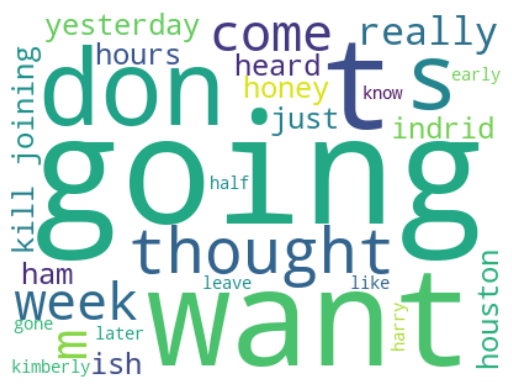

In [56]:
labels_query = pd.read_sql('SELECT * FROM hdbscan_labels', conn)

labels_query['word_cloud'] = labels_query['word_cloud_json'].apply(json.loads)

make_wordcloud(labels_query.loc[208, 'word_cloud'])


### Reading Representative Emails

In [ ]:
import textwrap
inspect_df = df_clean_2001_pick[df_clean_2001_pick.reduced_labels_dbscan_cut== 10]
inspect_df=inspect_df.sort_values(by='hdbscan_clusters_roberta_prob', ascending=False)

print(textwrap.fill(inspect_df.iloc[-2]['cleaned_email_body'], width=100))

# Print top 3 most similar emails found
topn=3

for i in range(min(len(inspect_df),topn)):
   
    print(f"Email: {inspect_df.iloc[i]['subject']} - date/folder: {inspect_df.iloc[i]['date_short']} - {inspect_df.iloc[i][['person_box','sub_mailbox']]} - similarity to accounting: {inspect_df.iloc[i].possible_accounting}")
    # print(inspect_df.iloc[i]['email_body'])
    print(textwrap.fill(inspect_df.iloc[i]['cleaned_email_body'], width=100))
    print('---------')

# inspect_df.sort_values(by='date_short')

In [62]:
## Translated to sqlite
import textwrap
import pandas as pd
import sqlite3

def representative_email(source_table='embeddings',topic_label='reduced_labels_dbscan_cut', topic_value=1):
    try:
        conn = sqlite3.connect(database_path) # connect to sqlite database
        filtered_emails = pd.read_sql(f'''SELECT email_body, hdbscan_clusters_roberta_prob  FROM
        {source_table}
    WHERE
        {topic_label} = {topic_value}
    order by hdbscan_clusters_roberta_prob DESC
    limit 3
        ''', conn)
        conn.close()

        return filtered_emails
    except Exception as e:
        print(f"Error loading data from database: {e}")
        return pd.DataFrame()

database_path = '../data/enron.db'

topic_label_in='hdbscan_clusters_roberta'
topic_value_in=3379

sample_representative_emails = representative_email(topic_label=topic_label_in, topic_value=topic_value_in)

for i in range(len(sample_representative_emails)):
    print(f"Email {i+1} with cluster probability {sample_representative_emails.iloc[i]['hdbscan_clusters_roberta_prob']}:")
    print(textwrap.fill(sample_representative_emails.iloc[i]['email_body'], width=100))
    print('-----------------------------------------------------------------------------------')

Email 1 with cluster probability 1.0:
David, I got hte same message from Don.  I found out he became a believer about a couple of months
ago and I have been spending a little time sharing Christ with him.  Im sure hes going through a
tough period now.  If you saved his address you may want to congraulate him into the family.  Thanks
for the prayers.  Its funny, but Im not too shook up about this.  what ever happens happens and I
know I cant do anything about it.  It must the the Spirit within me, but Im relatively calm about
the whole situation.  I find that when I hang aroundthe guys in the office and we start gripping, I
loose my focus and start looking like a carnal Christian.  So Im better off away from the troops and
just trnding to business.  Bill Kendrick seems to be pretty focused also. Im glad for that.  I know
hes under a lot of stress.       It seems the people tied to the pipeline assets are the safest.  If
it is a business unit with income coming in, Enron wants you.  The 

## Trends and Distribution from Aggregated data

In [58]:
from datetime import date

def load_topic_analysis(source_table='dbscan_topic_breakdown_analysis', topic=1):
    """Connects to the database and loads slices for analysis."""
    try:
        conn = sqlite3.connect(database_path) # connect to sqlite database
        df_analysis = pd.read_sql(f'''SELECT
                date_short, from_addr, person_box, sub_mailbox, sum(email_count) as email_count, sum(unique_email_count) as unique_email_count
                FROM {source_table}
                WHERE topic = {topic}
                group by date_short, from_addr, person_box, sub_mailbox
            
                ''', conn)

        conn.close()

        return df_analysis
    except Exception as e:
        print(f"Error loading data from database: {e}")
        return pd.DataFrame()
    

def make_analysis_charts(df):
    
    df['date_short_month']  = pd.to_datetime(df['date_short']).dt.strftime('%b')

    # Ensure all months are present, even with zero emails
    all_months = [date(2001, m, 1).strftime('%b') for m in range(1, 13)]
    df_trend = df.groupby(['date_short_month','sub_mailbox'])['email_count'].sum().reset_index()
    df_trend.columns = ['date_short_month','sub_mailbox' ,'email_count']
    
    month_map = {date(2001, m, 1).strftime('%b'): m for m in range(1, 13)}
    df_trend['month_num'] = df_trend['date_short_month'].map(month_map)
    df_trend = df_trend.sort_values('month_num')

    # st.dataframe(df_trend)
    # Define the correct order of the months
    month_order = [
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ]

    fig_line = px.bar(
        df_trend, 
        x='date_short_month', 
        y='email_count', 
        title='Total Email Count by Month',
        color='sub_mailbox',
        labels={'date_short_month': 'Month', 'email_count': 'Total Email Count'},
        category_orders={'date_short_month': month_order} # This is the key line
    )
    fig_line.update_layout(xaxis_title="Month", yaxis_title="Total Email Count")
    # st.plotly_chart(fig_line, use_container_width=True)

    # # --- Pie Charts for Aggregated Data ---
    # st.header("Email Distribution")
    # # col1, col2, col3 = st.columns(3)

    # # Pie chart for person_box
    # # with col1:
    # st.subheader("Emails by Person Box")
    df_person_box = df[~df['sub_mailbox'].isin(['sent', 'sent_items', '_sent_mail'])].groupby('person_box')['email_count'].sum().reset_index()
    fig_person = px.pie(
        df_person_box, 
        values='email_count', 
        names='person_box', 
        title='Distribution by Person Box'
    )
    # st.plotly_chart(fig_person, use_container_width=True)

    # Pie chart for from_addr
    # with col2:
    # st.subheader("Emails by Sender Address")
    df_from_addr = df.groupby('from_addr')['email_count'].sum().reset_index()
    fig_from = px.pie(
        df_from_addr, 
        values='email_count', 
        names='from_addr', 
        title='Distribution by Sender Address'
    )
    # st.plotly_chart(fig_from, use_container_width=True)

    # Pie chart for sub_mailbox
    # with col3:
    # st.subheader("Emails by Sub-Mailbox")
    df_sub_mailbox = df.groupby('sub_mailbox')['email_count'].sum().reset_index()
    fig_sub = px.pie(
        df_sub_mailbox, 
        values='email_count', 
        names='sub_mailbox', 
        title='Distribution by Sub-Mailbox'
    )
    # st.plotly_chart(fig_sub, use_container_width=True)

    return fig_line, fig_person, fig_from, fig_sub

In [59]:
df_scipy_analysis= load_topic_analysis(source_table='hdbscan_topic_breakdown_analysis', topic=3364)

fig_line1, fig_person1, fig_from1, fig_sub1 = make_analysis_charts(df_scipy_analysis)

In [61]:
fig_person1

In [60]:
fig_line1